# Airline Arrivals Project

# Introduction

In [2]:
import sys
import random
import numpy as np

from sklearn import linear_model, cross_validation, metrics, svm
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


In [3]:
# read 2008 year file
names = ['year', 'month', 'day', 'dow', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'Carrier', 'FlightNum', 
        'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest', 
        'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay', 
        'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'];
data = pd.read_csv('2008.csv')

data.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,3.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,...,3.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,3.0,10.0,0,NaN,0,2.0,0.0,0.0,0.0,32.0


In [4]:
data.shape

(7009728, 29)

In [5]:
#Drop Na value of 'ArrDelay'
df = data[data['Origin']=='ORD'].dropna(subset=['ArrDelay'])
df['ArrDelayed'] = df['ArrDelay'].apply(lambda x: x>=30)
print ("total flights: "+ str(df.shape[0]))
print ("total delays: "+ str(df['ArrDelayed'].sum()))

total flights: 334529
total delays: 71914


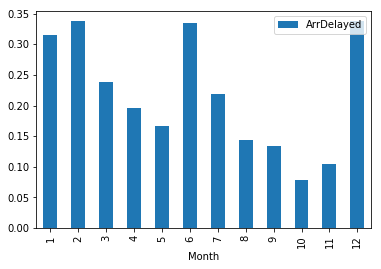

In [6]:
# Select a Pandas dataframe with flight originating from ORD

# Compute average number of delayed flights per month
grouped = df[['ArrDelayed', 'Month']].groupby('Month').mean()

# plot average delays by month
grouped.plot(kind='bar')

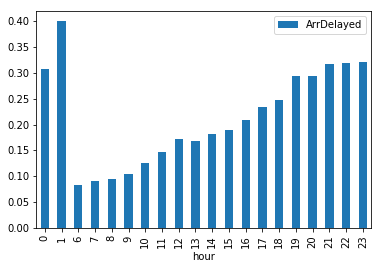

In [40]:
# Compute average number of delayed flights by hour
df['hour'] = df['CRSArrTime'].map(lambda x: int(str(int(x)).zfill(4)[:2]))
grouped = df[['ArrDelayed', 'hour']].groupby('hour').mean()

# plot average delays by hour of day
grouped.plot(kind='bar')

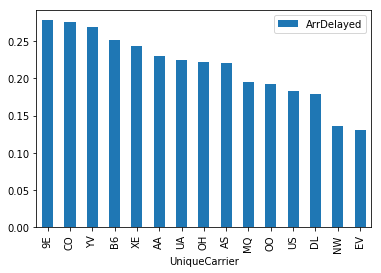

In [8]:
# Compute average number of delayed flights per carrier
grouped1 = df[['ArrDelayed', 'UniqueCarrier']].groupby('UniqueCarrier').filter(lambda x: len(x)>10)
grouped2 = grouped1.groupby('UniqueCarrier').mean()
carrier = grouped2.sort_values(['ArrDelayed'], ascending=False)

# display top 15 destination carriers by delay (from ORD)
carrier[:15].plot(kind='bar')

# Pre-processing and build a feature matrix

After exploring the data for a bit, we now move to building the feature matrix for our predictive model.

Let's look at possible predictive variables for our model:

<b>month</b>: winter months should have more delays than summer months <br>
<b>day of month</b>: this is likely not a very predictive variable, but let's keep it in anyway <br>
<b>day of week</b>: weekend vs. weekday <br>
<b>hour of the day</b>: later hours tend to have more delays <br>
<b>UniqueCarrier</b> (mã nhà cung cấp dịch vụ): we might expect some carriers to be more prone to delays than others <br>
<b>Destination airport</b>: we expect some airports to be more prone to delays than others <br>
<b>Distance</b>: interesting to see if this variable is a good predictor of delay <br>
We will also generate another feature: number of days from closest <b>national holiday</b>, with the assumption that holidays tend to be associated with more delays

In [9]:
#Function: convert hour format to int
def get_hour(val):
  return int(val.zfill(4)[:2])

US Holiday: https://www.timeanddate.com/calendar/?year=2008&country=1

In [29]:
# this array defines the dates of holiday in 2008 
import datetime
from datetime import date

holidays = [datetime.date(2008, 1, 1), datetime.date(2008, 1, 21), datetime.date(2008, 2, 18), datetime.date(2008, 5, 22), 
            datetime.date(2008, 5, 26), datetime.date(2008, 7, 4),
            datetime.date(2008, 9, 1), datetime.date(2008, 10, 13), datetime.date(2008, 11, 11), 
            datetime.date(2008, 11, 27), datetime.date(2008, 12, 25)]

# get number of days from nearest holiday
def days_from_nearest_holiday(d):
    d = pd.to_datetime(d).date()
    x = [(abs(d-h)).days for h in holidays]
    return min(x)

In [11]:
df.Cancelled.value_counts()

0    334529
Name: Cancelled, dtype: int64

In [30]:
df['Date'] = pd.to_datetime(dict(year=df.Year, month=df.Month, day=df.DayofMonth))

In [31]:
#calculate num of day nearest holiday
df['days_from_holiday'] = df['Date'].apply(days_from_nearest_holiday)

In [38]:
#Convert to hour
df['hour'] = df['CRSArrTime'].apply(lambda x: int(str(x).zfill(4)[:2]))

In [44]:
data = df[['ArrDelayed', 'Month', 'DayofMonth', 'DayOfWeek', 'hour', 'Distance', 'UniqueCarrier', 'Dest', 'days_from_holiday']]

In [49]:
# Create training set and test set
cols = ['Month', 'DayofMonth', 'DayOfWeek', 'hour', 'Distance', 'days_from_holiday']

train_y = data['ArrDelayed']
train_x = data[cols]

test_y = data['ArrDelayed']
test_x = data[cols]

print(train_x.shape)

(334529, 6)


In [51]:
# Create logistic regression model with L2 regularization
clf_lr = linear_model.LogisticRegression(penalty='l2', class_weight='auto')
clf_lr.fit(train_x, train_y)

# Predict output labels on test set
pr = clf_lr.predict(test_x)

# display evaluation metrics
cm = confusion_matrix(test_y, pr)
print("Confusion matrix")
print(pd.DataFrame(cm))
report_lr = precision_recall_fscore_support(list(test_y), list(pr), average='micro')
print("\nprecision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % \
        (report_lr[0], report_lr[1], report_lr[2], accuracy_score(list(test_y), list(pr))))

Confusion matrix
        0       1
0  155014  107601
1   27390   44524

precision = 0.60, recall = 0.60, F1 = 0.60, accuracy = 0.60



In [54]:
# Create Random Forest classifier with 50 trees
clf_rf = RandomForestClassifier(n_estimators=50, n_jobs=-1)
clf_rf.fit(train_x, train_y)

# Evaluate on test set
pr = clf_rf.predict(test_x)

# print results
cm = confusion_matrix(test_y, pr)
print("Confusion matrix")
print(pd.DataFrame(cm))
report_svm = precision_recall_fscore_support(list(test_y), list(pr), average='micro')
print("\nprecision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % \
        (report_svm[0], report_svm[1], report_svm[2], accuracy_score(list(test_y), list(pr))))

Confusion matrix
        0      1
0  258529   4086
1    8201  63713

precision = 0.96, recall = 0.96, F1 = 0.96, accuracy = 0.96

